# General Linear Model Analysis

## Load the data from the previous steps

In [1]:
from nilearn.glm.first_level import FirstLevelModel
import nibabel as nib
from nilearn import plotting

TR = 0.72
fmri_img_path = "dataset/derivatives/preprocessed_data/subject101410/fMRI/tfMRI_MOTOR_moco_smoothed_4mm.nii.gz"

fmri_img = nib.load(fmri_img_path)

data = fmri_img.get_fdata()

print(f"File loaded! Data shape: {data.shape}")

File loaded! Data shape: (91, 109, 91, 568)


Assume we also have `n_vols` and `vol_shape`.

In [2]:
n_vols = data.shape[3]
vol_shape = data.shape[:3]

## 3. Design Matrix Investigation

First, we load the data relative to the events in both recordings.

In [3]:
import pandas as pd

events_RL_df = pd.read_csv("dataset/subject101410/fMRI/tfMRI_MOTOR_RL/events_RL.csv", sep=',')
events_RL_df = events_RL_df.rename(columns={'condition': 'trial_type'})

events_LR_df = pd.read_csv("dataset/subject101410/fMRI/tfMRI_MOTOR_LR/events_LR.csv", sep=',')
events_LR_df = events_LR_df.rename(columns={'condition': 'trial_type'})

print("EVENTS LR: \n", events_LR_df.head())
print("\n=================================\n")
print("EVENTS RL: \n", events_RL_df.head())
print("\n")

EVENTS LR: 
    onset  duration trial_type
0    0.0       8.0        NaN
1    8.0       3.0        cue
2   11.0      12.0         rh
3   23.0       3.0        cue
4   26.0      12.0         lf


EVENTS RL: 
    onset  duration trial_type
0    0.0       8.0        NaN
1    8.0       3.0        cue
2   11.0      12.0         lh
3   23.0       3.0        cue
4   26.0      12.0         rf




Now, we concatenate the two events tables after shifting the onset of the second run

In [4]:
run1_duration = 0
for i, duration in enumerate(events_LR_df['duration']):
    run1_duration = run1_duration + duration

events_RL_df['onset'] = events_RL_df['onset'] + run1_duration

events_df = pd.concat([events_LR_df, events_RL_df], ignore_index=True)
print("Events concatenated: \n", events_df)

Events concatenated: 
     onset  duration trial_type
0     0.0       8.0        NaN
1     8.0       3.0        cue
2    11.0      12.0         rh
3    23.0       3.0        cue
4    26.0      12.0         lf
5    38.0       3.0        cue
6    41.0      12.0          t
7    53.0       3.0        cue
8    56.0      12.0         rf
9    68.0       3.0        cue
10   71.0      12.0         lh
11   83.0      15.0   fixation
12   98.0       3.0        cue
13  101.0      12.0          t
14  113.0       3.0        cue
15  116.0      12.0         lf
16  128.0       3.0        cue
17  131.0      12.0         rh
18  143.0      16.0   fixation
19  159.0       3.0        cue
20  162.0      12.0         lh
21  174.0       3.0        cue
22  177.0      12.0         rf
23  189.0      15.5   fixation
24  204.5       8.0        NaN
25  212.5       3.0        cue
26  215.5      12.0         lh
27  227.5       3.0        cue
28  230.5      12.0         rf
29  242.5      15.0   fixation
30  257.5       

Now we try to build a Design matrix based off the dimension of our data and the events that are indicated in the related file. We use `drift_order=4`, but the parameter can be easily changed and/or tuned.

### IMPORTANT
This is the first version of a design matrix, more experimentation is needed with additional regressors.

/opt/conda/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


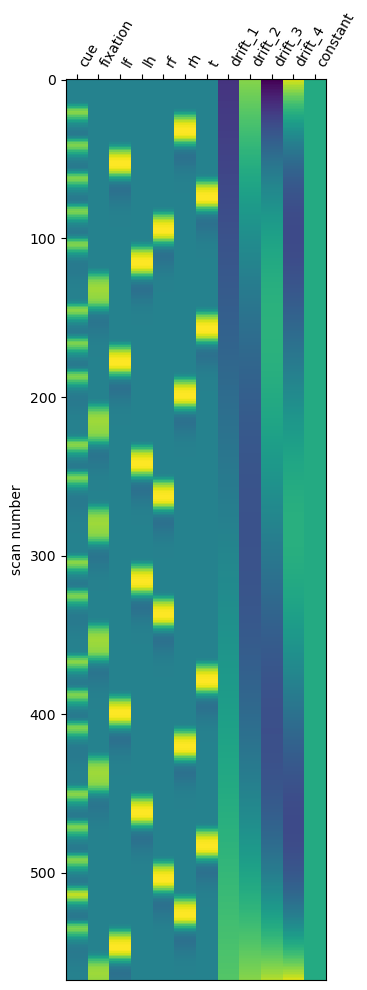

In [5]:
import numpy as np
import nibabel as nib
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

frame_times = np.arange(n_vols) * TR

# Create a Design Matrix
design_matrix = make_first_level_design_matrix(
    frame_times,
    events=events_df,
    hrf_model='spm',
    drift_model='polynomial', 
    drift_order=4
)

# Inspect the   Design Matrix
n_features = design_matrix.shape[1]
plot_design_matrix(design_matrix);

## 4. Running the GLM

In [6]:
from nilearn.glm.first_level import FirstLevelModel

fmri_glm = FirstLevelModel(t_r=TR, noise_model='ar1')

print("Now the model will fit the data (Slow process) ...")
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrix)
print("Fit completed")

Now the model will fit the data (Slow process) ...
Fit completed


Create statistical maps for each (meaningful) regressor.

In [7]:
import numpy as np

labels = ['cue', 'fixation', 'lf', 'lh', 'rf', 'rh', 't']

conditions = {}
for i, label in enumerate(labels):
    vec = np.zeros(n_features)
    vec[i] = 1
    conditions[label] = vec

for key, value in conditions.items():
    print(f"{key:<10}: {value}")

cue       : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
fixation  : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
lf        : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
lh        : [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
rf        : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
rh        : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
t         : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


Now let's save the statistical maps into specific files.

In [8]:
import os
import os.path as op

glm_output_dir = op.join(os.getcwd(), 'dataset/derivative/preprocessed_data/subject101410/GLM')
os.makedirs(glm_output_dir, exist_ok=True)

for regressor in labels:
    print(f"Computing {regressor} statistical map")
    stat_map = fmri_glm.compute_contrast(
        regressor,
        output_type = 'z_score'
    )
    filename = os.path.join(glm_output_dir, f"zmap_{regressor}.nii.gz")
    nib.save(stat_map, filename)
    print(f"  --> Map saved: {filename}")

Computing cue statistical map
  --> Map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_cue.nii.gz
Computing fixation statistical map
  --> Map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_fixation.nii.gz
Computing lf statistical map
  --> Map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_lf.nii.gz
Computing lh statistical map
  --> Map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_lh.nii.gz
Computing rf statistical map
  --> Map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_rf.nii.gz
Computing rh statistical map
  --> Map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_rh.nii.gz
Computing t statistical map
  --> Map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_t.nii.gz


Let's display the results for the right hand map

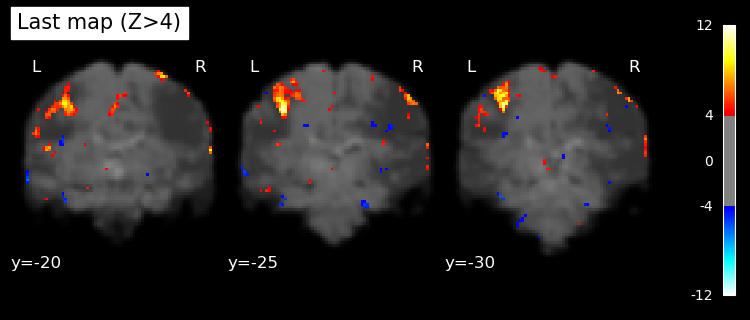

In [89]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_img),
stat_map = nib.load('/data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_rh.nii.gz')
plot_stat_map(stat_map, bg_img=mean_img_[0], threshold=4,
              display_mode='y', cut_coords=[-20, -25, -30], black_bg=True,
              title='Last map (Z>4)')
plt.show()

## 5. Hand Motion against Feet motion

In [103]:
hands_vs_feet = conditions['lh'] + conditions['rh'] - conditions['lf'] - conditions['rf']

print(f"Computing Hands vs. Feet contrast...")
stat_map = fmri_glm.compute_contrast(
    hands_vs_feet,
    output_type='z_score'
)
hands_vs_feet_filename = os.path.join(glm_output_dir, f"zmap_hands_vs_feet.nii.gz")
nib.save(stat_map, hands_vs_feet_filename)
print(f"  --> Hands vs. Feet contrast map saved: {hands_vs_feet_filename}")

Computing Hands vs. Feet contrast...
  --> Hands vs. Feet contrast map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_hands_vs_feet.nii.gz


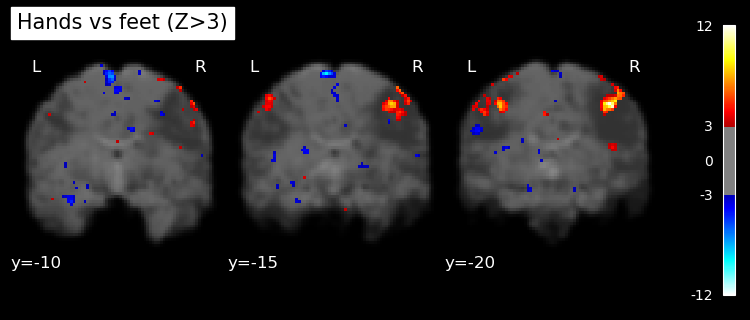

In [105]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_img),
plot_stat_map(stat_map, bg_img=mean_img_[0], threshold=3,
              display_mode='y', cut_coords=[-10, -15, -20], black_bg=True,
              title='Hands vs feet (Z>3)')
plt.show()

## 6. Results against the Atlas

In [106]:
from nilearn import datasets

print("Loading of the AAL atlas...")
atlas_aal = datasets.fetch_atlas_aal(verbose=0)
# atlas_aal.maps is the path to the nii.gz file
# atlas_aal.labels is a list of region names


print(f"Atlas has {len(atlas_aal.labels)} regions.")
print("Example of some regions:", atlas_aal.labels[13:16])

Loading of the AAL atlas...
Atlas has 116 regions.
Example of some regions: ['Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R']


In [107]:
import nibabel as nib
from nilearn.maskers import NiftiLabelsMasker
import numpy as np

# Load the contrast map
z_map = nib.load(hands_vs_feet_filename) 
print(z_map.shape)

# standardize=False
masker = NiftiLabelsMasker(
    labels_img=atlas_aal.maps, 
    standardize=False,
    memory='nilearn_cache',
    verbose=0
)

# We need to expand z_map to 4d
z_map_3d = z_map.get_fdata()
z_map_4d = nib.Nifti1Image(np.expand_dims(z_map_3d, axis=3), z_map.affine)

print("Extraction of average values for each region...")
region_values = masker.fit_transform(z_map_4d)

# region_values now is an array like: [[val1, val2, ... val116]]
region_values_1d = region_values.ravel()

print("Extraction finished.")

(91, 109, 91)
Extraction of average values for each region...
Extraction finished.


In [108]:
import pandas as pd

# Create DataFrame for a clean report
report_df = pd.DataFrame({
    'AAL_region': atlas_aal.labels,
    'avg_zscore': region_values_1d
})

# Remove empty regions
report_df = report_df[report_df['avg_zscore'] != 0]

# Sort to find the maximums
report_ordered = report_df.sort_values(by='avg_zscore', ascending=False)

# Print the top 10 regions with the most Contrast
print("\n Regions with Maximum Contrast")
print(report_ordered.head(10))


 Regions with Maximum Contrast
              AAL_region  avg_zscore
1           Precentral_R    0.749477
56         Postcentral_L    0.636578
57         Postcentral_R    0.552058
23  Frontal_Sup_Medial_R    0.515656
24     Frontal_Med_Orb_L    0.474631
25     Frontal_Med_Orb_R    0.446743
0           Precentral_L    0.443967
34       Cingulum_Post_L    0.377243
98         Cerebelum_6_L    0.352210
26              Rectus_L    0.349959


Plot the contrast map against the Parcellation Atlas.

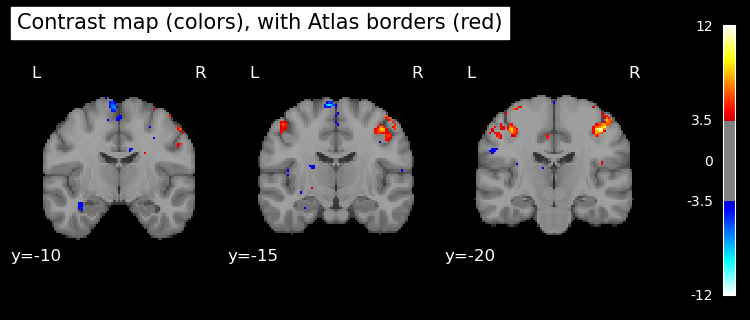

In [109]:
display = plotting.plot_stat_map(
    z_map, 
    threshold=3.5,
    display_mode='y',
    cut_coords=[-10,-15,-20],
    title="Contrast map (colors), with Atlas borders (red)",
    black_bg=True
)

"""display.add_edges(
    atlas_aal.maps,
    color='g'
)
"""
plt.show()